#### **Library imports**

In [26]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Load dataset**

In [27]:
dataset = 'steam'

train_edges = np.load('data/' + dataset + '/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = user_list.max() + 1 
n_items = item_list.max() + 1
n_samples = len(rating_list)

n_users, n_items, n_samples

(1698, 1397, 168848)

#### **Defining collaborative filtering**

In [28]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

class NCF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.fc1 = nn.Linear(n_factors * 2, n_factors)
        self.fc2 = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()
        swish = nn.SiLU()

        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.concat([u, i], dim = 1)
        x = swish(x)
        x = self.fc1(x)
        x = swish(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Code for surrogate meta-attack (surrogate-CF-SGD, evaluation-CF-Adam, same-init)**

In [43]:
# model settings
algorithm = 'meta'
surrogate = 'CF2'
target = 'CF2'
opt_surrogate = 'sgd'
opt_target = 'adam'
lr_surrogate = 150
lr_target = 0.005
seed_surrogate = 50
seed_target = 0

# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparameters
T = 250
Delta = 5000 # 5% ~ 10K perturbations for movielens
n_factors = 64
save_results = True
retain_graph = True 
create_graph = False

if Delta < 100:
    save_results = False

# initialize list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []

perturbations['accuracy_before_eval'] = []
perturbations['accuracy_after_eval'] = []
perturbations['loss_before_eval'] = []
perturbations['loss_after_eval'] = []

# print hyperparam configuration
print('-> Algorithm: ', algorithm)
print()
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print()
print('-> Surrogate: ', surrogate)
print('-> Target: ', target)
print('-> Surrogate optimizer: ', opt_surrogate)
print('-> Target optimizer: ', opt_target)
print('-> Surrogate learning rate: ', lr_surrogate)
print('-> Target learning rate: ', lr_target)
print('-> Surrogate seed: ', seed_surrogate)
print('-> Target seed: ', seed_target)
print()
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)
if 'NCF' in surrogate:
    ratings = ratings.reshape((n_samples, 1))
perturbs = torch.ones_like(ratings).bool()

# sample random negative edges to perturb
if 'base' in algorithm:
    edges = ratings.detach().to('cpu').numpy()
    neg_edges = np.where(edges == 0)[0]
    np.random.seed(0)
    edges_to_perturb = np.random.choice(neg_edges, size=Delta, replace = True) # sample Delta edges randomly and perturb one by one inside loop 

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # define surrogate model and it's parameters
    if 'NCF' in surrogate:
        model = NCF(n_users, n_items, n_factors)
    else:
        model = CollaborativeFiltering(n_users, n_items, n_factors)
    model.to(device)

    # reset model paramters 
    torch.manual_seed(seed_surrogate)
    for layer in model.children():
        layer.reset_parameters()

    # define optimizer and loss function
    if 'adam' in opt_surrogate:
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_surrogate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr = lr_surrogate)
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()
    model.eval()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())
    
    # compute meta gradient
    if 'meta' in algorithm:
        meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model
    if 'NCF' in target:
        eval_model = NCF(n_users, n_items, n_factors)
    else:
        eval_model = CollaborativeFiltering(n_users, n_items, n_factors)
    eval_model.to(device)

    # reset evaluation model parameters
    torch.manual_seed(seed_target)
    for layer in eval_model.children():
        layer.reset_parameters()

    # define optimizer and loss function for evaluation
    if 'adam' in opt_target:
        optimizer_eval = torch.optim.Adam(eval_model.parameters(), lr = lr_target)
    else:
        optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr_target)
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings and perturbs for eval model
    ratings_eval = ratings.detach().clone()
    perturbs_eval = perturbs.detach().clone()

    # reshape ratings and perturbs if necessary
    if surrogate != target:
        if 'NCF' in target:
            ratings_eval = ratings_eval.reshape((n_samples, 1))
            perturbs_eval = perturbs_eval.reshape((n_samples, 1))
        else:
            ratings_eval = ratings_eval.reshape((n_samples))
            perturbs_eval = perturbs_eval.reshape((n_samples))

    # inner train  evaluation model
    eval_model.train()
    for i in range(T):
        y_hat = eval_model(users, items)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()
    eval_model.eval()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items)
        perturbations['accuracy_before_eval'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss_before_eval'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs_eval)
        ratings_masked = torch.masked_select(ratings_eval, perturbs_eval)
        perturbations['accuracy_after_eval'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after_eval'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

    # select best edge and perform perturbation
    with torch.no_grad():
        if 'meta' in algorithm:
            mask = ratings.detach().int()
            meta_grad[mask == 1] = 0
            best_edge = meta_grad.argmax().item()
            ratings[best_edge] = 1
            perturbs[best_edge] = False

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(meta_grad[best_edge].item())

        else:
            best_edge = edges_to_perturb[delta]
            ratings[best_edge] = 1 
            perturbs[best_edge] = False

            perturbations['edges'].append(best_edge)
            perturbations['metagrad'].append(-1)

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# process results
perturbations = pd.DataFrame(perturbations)
filename = '{}({})-{}({})-{}-D={}-T={}-diffinit'.format(surrogate, opt_surrogate, target, opt_target, algorithm, Delta, T)
if save_results:
    perturbations.to_csv('results/' + dataset + '/' + filename + '.csv')

-> Algorithm:  meta

-> T:  250
-> Delta: 5000 (2.96%)
-> Embedding size:  64
-> Device:  cuda:6

-> Surrogate:  CF2
-> Target:  CF2
-> Surrogate optimizer:  sgd
-> Target optimizer:  adam
-> Surrogate learning rate:  150
-> Target learning rate:  0.005
-> Surrogate seed:  50
-> Target seed:  0

-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 5000/5000 [1:09:16<00:00,  1.20it/s]


-> Execution time: 01h 09m 17s


In [45]:
print('Max meta-gradient: ', perturbations['metagrad'].max())
perturbations

Max meta-gradient:  0.00018201542843598872


,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after,accuracy_before_eval,accuracy_after_eval,loss_before_eval,loss_after_eval
0,162077,0.000182,0.934290,0.934290,0.252867,0.252867,0.958744,0.958744,0.201953,0.201953
1,134851,0.000181,0.934278,0.934284,0.253042,0.252869,0.958691,0.958690,0.201962,0.201963
2,49642,0.000170,0.934266,0.934277,0.252557,0.252355,0.958697,0.958696,0.202544,0.202546
3,60478,0.000160,0.934266,0.934277,0.252577,0.252374,0.958685,0.958684,0.202541,0.202545
4,159306,0.000158,0.934207,0.934223,0.252627,0.252388,0.958667,0.958666,0.202541,0.202545
...,...,...,...,...,...,...,...,...,...,...
4995,81156,0.000045,0.909042,0.916102,0.285754,0.270394,0.956926,0.956131,0.205504,0.207977
4996,10353,0.000045,0.909037,0.916089,0.285795,0.270432,0.956890,0.956095,0.205520,0.207995
4997,163850,0.000045,0.909025,0.916082,0.285800,0.270436,0.956902,0.956113,0.206068,0.208562
4998,64378,0.000045,0.909042,0.916106,0.285798,0.270438,0.956872,0.956076,0.205518,0.207996


#### **Plots**

Filename:  CF2(sgd)-CF2(adam)-meta-D=5000-T=250-diffinit


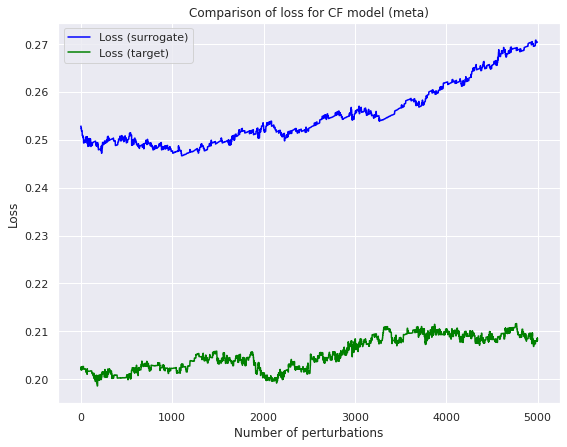

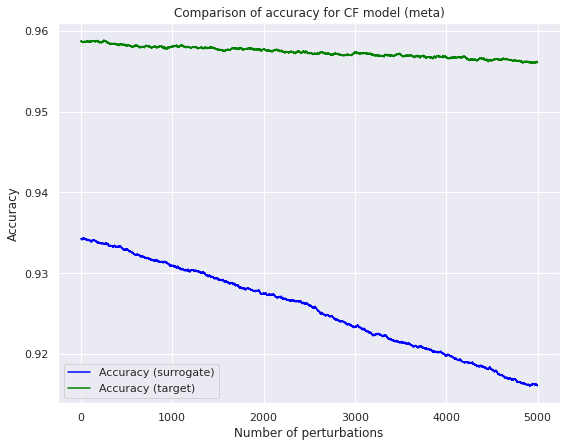

In [46]:
# Process perturbations data
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges (surrogate)', 'Accuracy excluding perturbed edges (surrogate)', 'Loss including perturbed edges (surrogate)', 'Loss excluding perturbed edges (surrogate)', 'Accuracy including perturbed edges (target)', 'Accuracy excluding perturbed edges (target)', 'Loss including perturbed edges (target)', 'Loss excluding perturbed edges (target)']
perturbations_reset

# Figure specifications
sns.set_theme()
figsize = (9, 7)
print('Filename: ', filename)

# Loss plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of loss for CF model ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Loss')
plt.legend(labels = ['Loss (surrogate)', 'Loss (target)'], loc = 'upper left')
if save_results: 
    fig.savefig('plots/' + dataset + '/losses-' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (surrogate)', color = 'blue').set_title('Comparison of accuracy for CF model ({})'.format(algorithm))
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges (target)', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Accuracy')
plt.legend(labels = ['Accuracy (surrogate)', 'Accuracy (target)'])
if save_results:
    fig.savefig('plots/' + dataset + '/accuracy-' + filename)
plt.show()